# Introduction to CAD systems and image processing basic

## Teaching assistants

- Gabriel Humpire: g.humpiremamani@radboudumc.nl
- Mehmet Dalmis: mehmet.dalmis@radboudumc.nl


## Instructions

* Groups: You can work in pairs or alone
* Deadline for this assignment: 
 * Today (February 3rd) until midnight
 * 1 point penalization per day
* Send your notebook to: g.humpiremamani@radboudumc.nl and mehmet.dalmis@radboudumc.nl
* The grades will be available before February 10th

This notebooks contains cells with snippets of code that we provide in order to load and visualize data, but also some convenience functions that could be useful to develop your assingment.


We also provide templates for functions that have to be implemented, with a given list of input variables and some output variables. **Feel free to modify the input and output variables to adapt them to your favourite implementation.** However, this should at least provide the outputs required to develop the rest of the notebook.


Your submission should contain the notebook with your code implemented, as well as your answers to questions, which will be used to grade your assignment.

## Introduction

In this first assignment, we are going to implement and apply some basic image processing techniques, and we will get familiar with some kind of medical imaging data.
In particular, we will be working with data from:
* mammography (breast, 2D)
* histopathology (colon, 2D)
* chest CT (lungs, 3D)

We will implement the following techniques:
1. conversion of raw mammography data into a gray-scale image
2. stain normalization in digital pathology with histogram matching
3. trachea detection in chest CT with blob detection

### Data

The data necessary to develop the code in this assignment can be downloaded from this link:
https://surfdrive.surf.nl/files/index.php/s/oA0nuigvODrutGJ (pwd:ismi2017)

You should have received the same link via Blackboard.
If you experienced any problems with downloading the data, ask your teaching assistant(s).
We assume the content of the downloaded data is in **'./data'**. If not, adjust the paths in the notebook.

## Libraries

First, we import the basic libraries necessary to develop this assignment. Feel free to include more libraries if needed.


In [65]:
import SimpleITK as sitk
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline 
import numpy as np
from PIL import Image
import os
import dicom
from IPython import display
import time
from mpl_toolkits.mplot3d import Axes3D
import copy
matplotlib.rcParams['figure.figsize'] = (20, 12)
import scipy.signal

## 1. Gray-scale transformation of breast tomography

The first assignment consists in reconstructing a gray-scale mammography image from the raw data acquired with the mammography machine. As we have seen in the lecture, there are several steps that have to be applied to reconstruct a gray-scale image that can actually be read by radiologists with the aim of detecting tumors, masses, cysts, micro-calcifications.

### Read image

In your local data folder, you can find a file containing raw mammography data and the corresponding processed gray-level version. The processed version comes from the vendor and is the result of several filtering and enhancement steps that are proprietary. Our goal is however to do a good job at deriving a gray-level image from raw data.
The files are in ITK format, with extension .mhd, and can be opened using the library SimpleITK. You can find documentation on SimpleITK at this link: http://www.simpleitk.org/SimpleITK/help/documentation.html.
In the next cell, we provide the function used to read the raw data and the gray-level images.
Furthermore, we indicate which steps have to be implemented.
Complete the assignment by implementing the steps indicated.

In [66]:
# raw and gray-level data in ITK format
raw_img_filename = './data/raw_mammography.mhd'
out_img_filename = './data/processed_mammography.mhd'

# read ITK files using SimpleITK
raw_img = sitk.ReadImage(raw_img_filename)
out_img = sitk.ReadImage(out_img_filename)

# print image information
print('image size: {}'.format(raw_img.GetSize()))
print('image origin: {}'.format(raw_img.GetOrigin()))
print('image spacing: {}'.format(raw_img.GetSpacing()))
print('image width: {}'.format(raw_img.GetWidth()))
print('image height: {}'.format(raw_img.GetHeight()))
print('image depth: {}'.format(raw_img.GetDepth()))

image size: (2560, 3328)
image origin: (0.0, 0.0)
image spacing: (0.07000000029802322, 0.07000000029802322)
image width: 2560
image height: 3328
image depth: 0


#### Question

What is the resolution of this image?

8.5 mpx (2560*3328)

### Convert ITK image to Numpy array

In order to easily manipulate data, it is convenient to convert it into a numpy format, which can be transformed using the numpy library, and can easily be visualized using the pylab/matplotlib library.
Please check the documentation in http://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/ to find the proper function to transform the SimpleITK image to numpy. Write your code below:
* out_np: should contain the numpy array from out_img
* raw_np: should contain the numpy array from raw_img

Note: If you are not familiar with Numpy, you can check briefly this tutorial: http://cs231n.github.io/python-numpy-tutorial/

In [67]:
# convert the ITK image into numpy format
# >> YOUR CODE HERE <<<
out_np = sitk.GetArrayFromImage(out_img)
raw_np = sitk.GetArrayFromImage(raw_img)

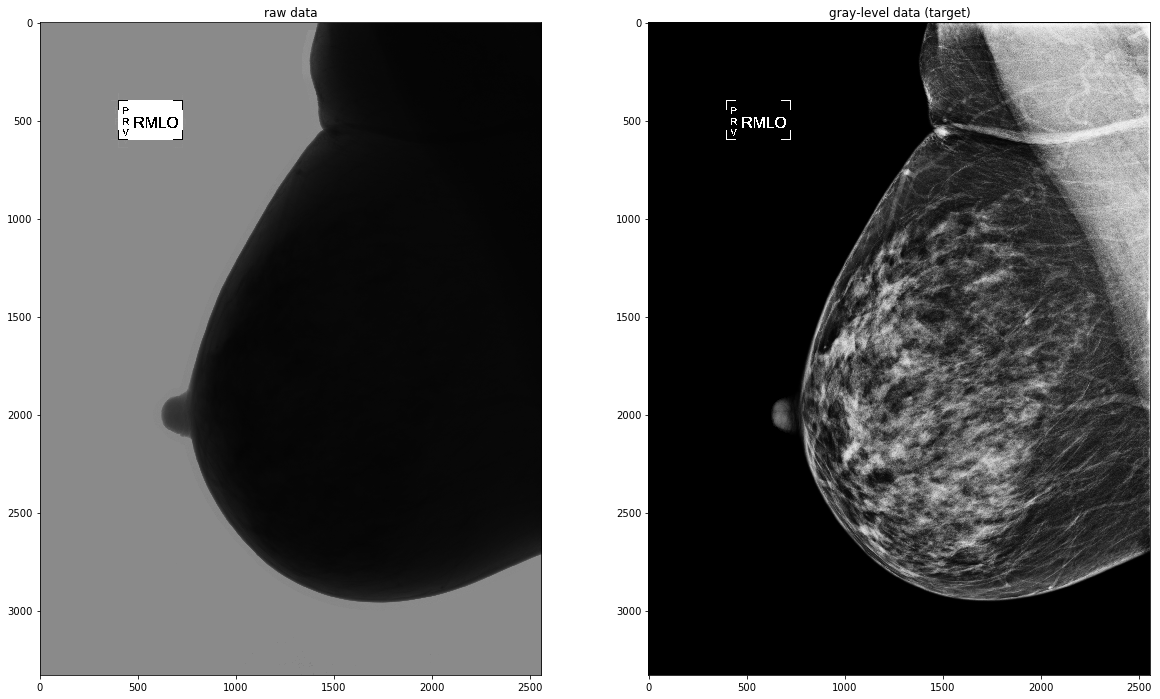

In [68]:
assert(out_np is not None),"out_np can not be None"
assert(raw_np is not None),"raw_np can not be None"

# visualize the two numpy arrays
plt.subplot(1,2,1)
plt.imshow(raw_np, cmap='gray')
plt.title('raw data')
plt.subplot(1,2,2)
plt.imshow(out_np, cmap='gray')
plt.title('gray-level data (target)')
plt.show()

### Image processing

Implement at least the three main steps necessary to convert raw data into a gray-level image:
1. Logaritmic transformation
2. Intensity inversion
3. Contrast stretching

Slide 19 of the previous lecture shows this approach
<img src="images/raw2gray.png">

#### Logaritmic transformation

In [69]:
# logarithmic transformation
# >> YOUR CODE HERE <<<
mammo_log = np.log(raw_np)
mammo_log[np.isneginf(mammo_log)] = 0 # we dont want -inf in our array
mammo_log = mammo_log *(255/np.max(mammo_log))
print(np.max(mammo_log))


255.0


C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


0.0


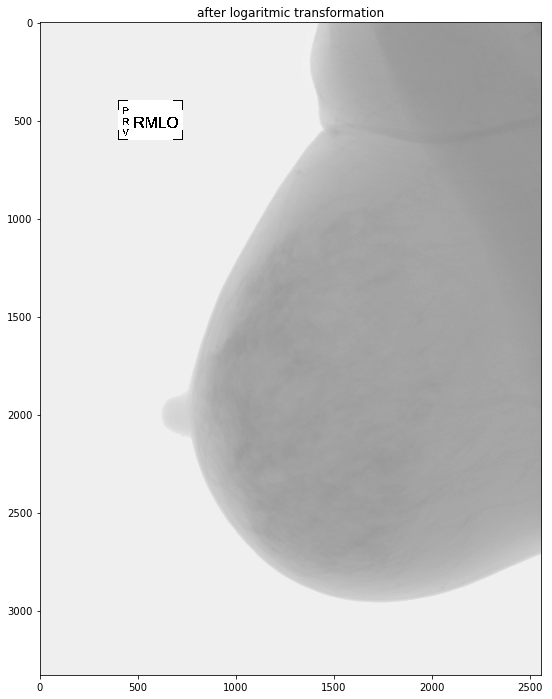

In [70]:
assert(mammo_log is not None),"mammo_log can not be None"
print(np.min(mammo_log))
# visualize the result
plt.imshow(mammo_log, cmap='gray')
plt.title('after logaritmic transformation')

#### Intensity inversion

In [71]:
# intensity inversion
# >> YOUR CODE HERE <<<
mammo_inv = (mammo_log-np.max(mammo_log))*-1

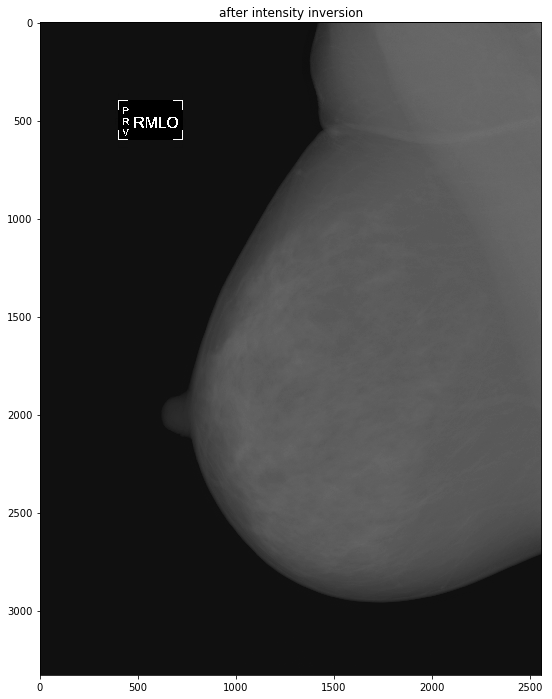

In [72]:
assert(mammo_inv is not None),"mammo_inv can not be None"

# visualize the result
plt.imshow(mammo_inv, cmap='gray')
plt.title('after intensity inversion')

#### Contrast stretching

In order to apply the contrast stretching operation, let's first define a general contrast stretching function. The inputs should be at least (1) the input signal, (2) the window range values p0 and pk, as defined in the lecture.

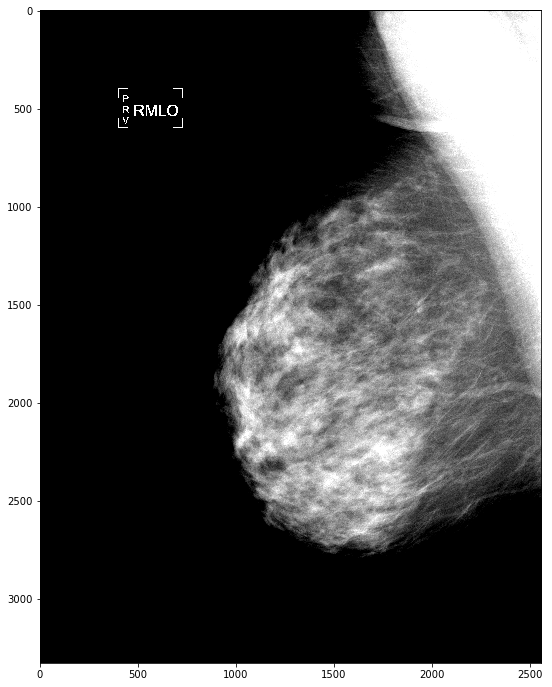

In [73]:
# contrast stretching
def cs(x, p0, pk):
    q0 = 0#np.min(x) # we can also just set 0 here, in case we didn't rescale before
    qk = 255#np.max(x) # we can also just set 255 here, in case we didn't rescale before
    x_r = (x-p0)/(pk-p0)

    x_r[x_r<=0] = 0
    x_r[x_r>1]  = 1
    x_r = x_r * (qk -q0) + q0
    return x_r


# pick proper values for p0 and pk
p0 = 85
pk = 100

assert(p0 is not None),"p0 can not be None"
assert(pk is not None),"pk can not be None"

mammo_cs = cs(mammo_inv, p0, pk)
assert(mammo_cs is not None),"mammo_cs can not be None"

# visualize the result
plt.imshow(mammo_cs, cmap='gray')
plt.show()

You will notice that the result at this stage is already much more readable than the raw data you started from. However, the result is still not as good as the one provided by the mammography manufacturer. In order to check for the differences, we will visualize the histogram of the mammography after inversion (before contrast stretching), after contrast stretching and the target one.

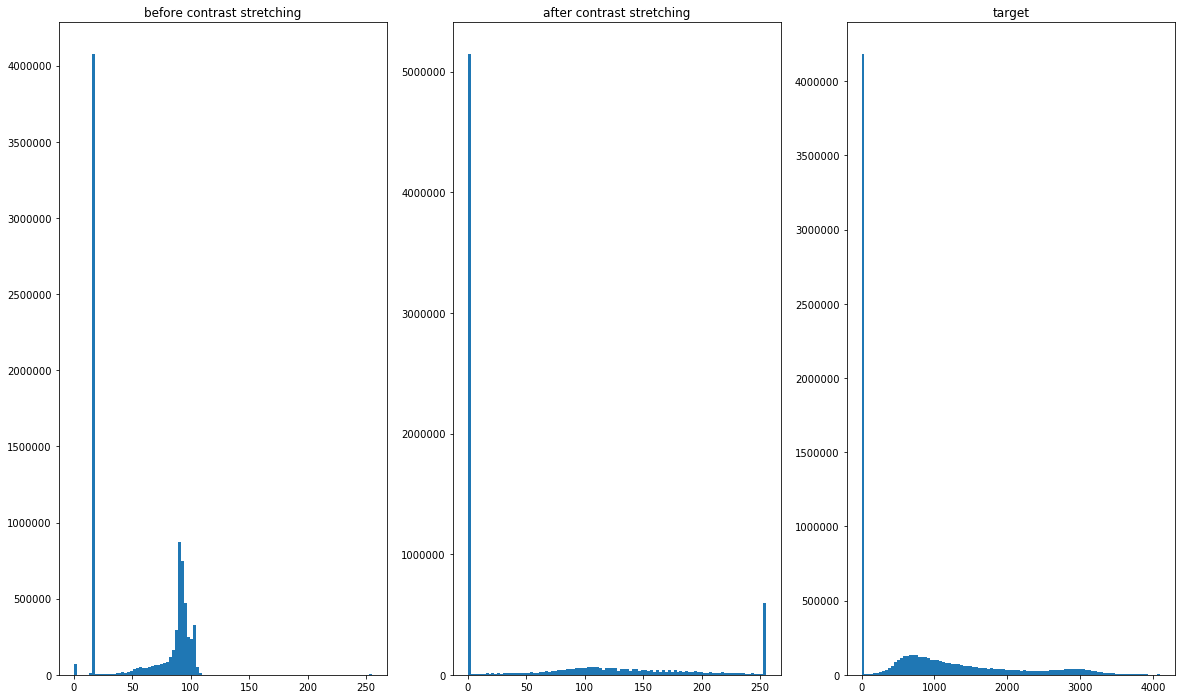

In [74]:
# visualize and compare histograms
plt.subplot(1,3,1)
plt.hist(mammo_inv.flatten(),100)
plt.title('before contrast stretching')
plt.subplot(1,3,2)
plt.hist(mammo_cs.flatten(),100)
plt.title('after contrast stretching')
plt.subplot(1,3,3)
plt.hist(out_np.flatten(),100)
plt.title('target')
plt.show()

#### Question

How did you define the values of p0 and pk? How much does the result change when this parameters sligthly change? Could you deduce this by having a look at the histogram?

We just tried it out. When we changed the upper bound slightly, the results changed drastically from 100->110. This can also be seen from the histrogram, because above 100 there are almost no values in the image.

#### Histogram equalization/matching instead of contrast stretching

The step of contrast stretching could be replaced by a histogram equalization step. In this way, we assume that the target image is known and accessible, from which we will learn some intensity value correspondance function, known as look-up-table (LUT). A LUT is a table that has entries that correspond to all possible values in the input image, and each value is mapped to an output value, with the aim of mimicking the intensity distribution of the target image, the vendor mammography in our case.

Implement a function that takes as input the histogram to transform and the target histogram and return a LUT.

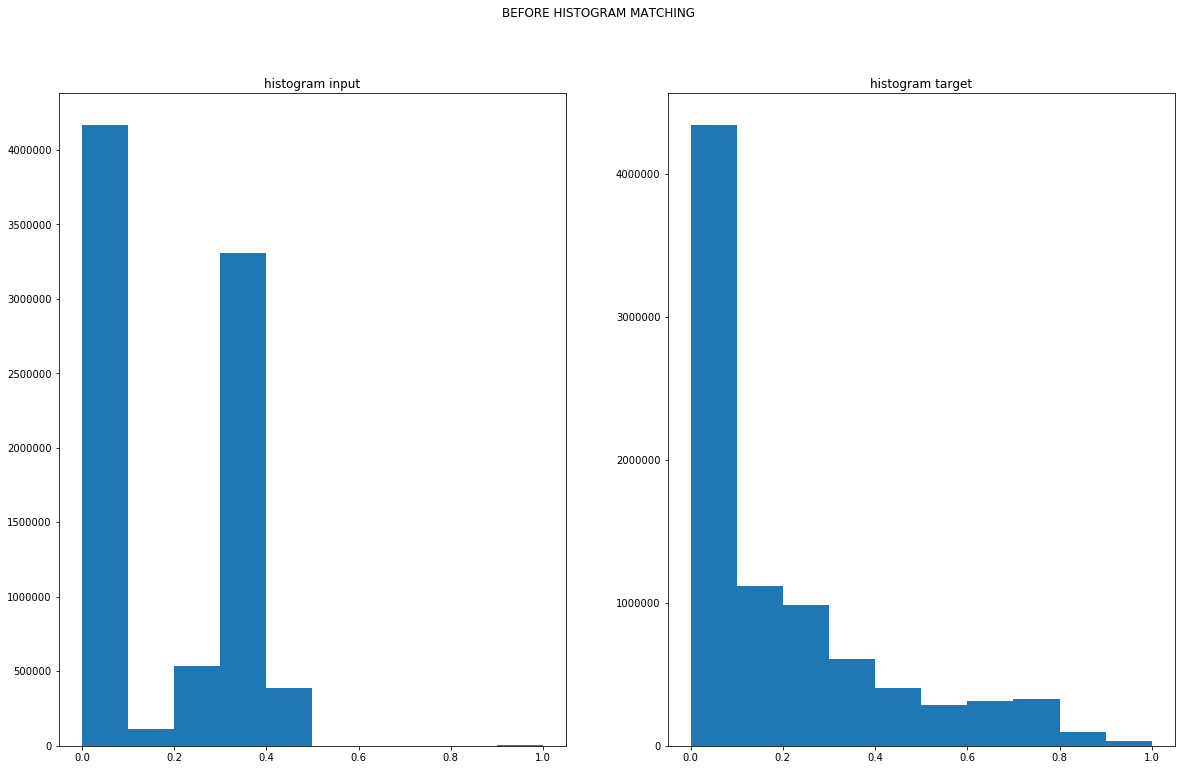

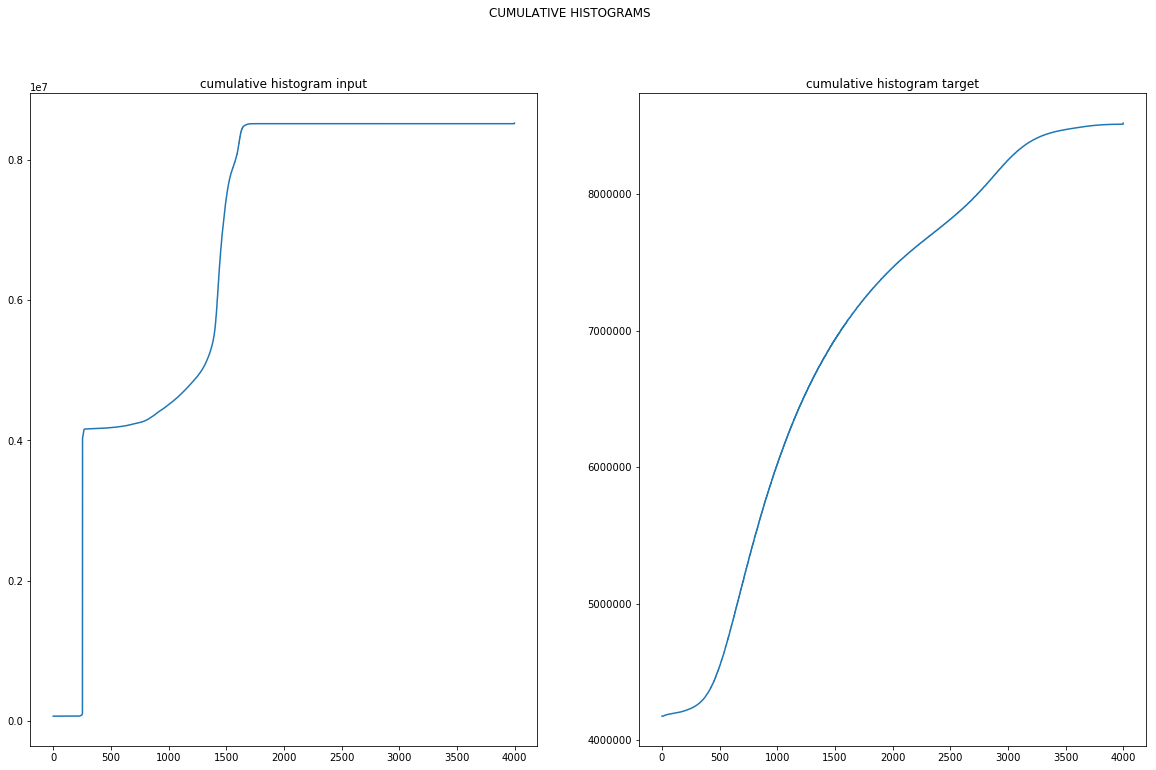

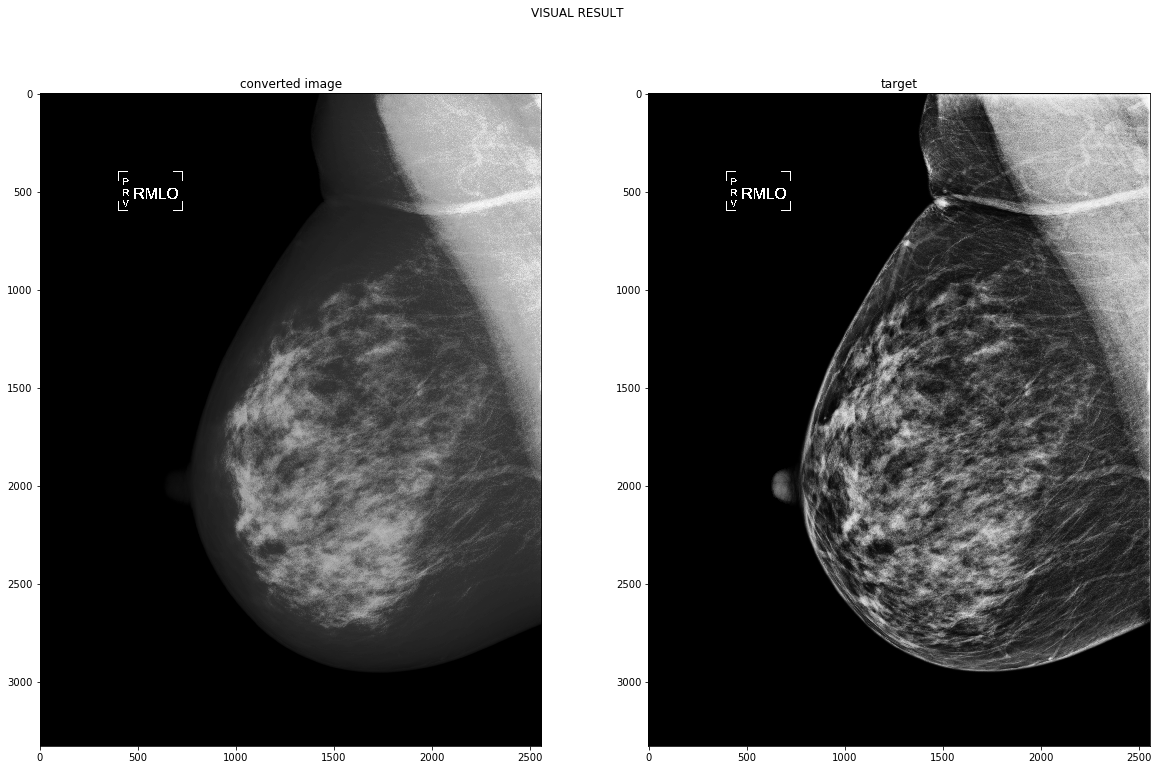

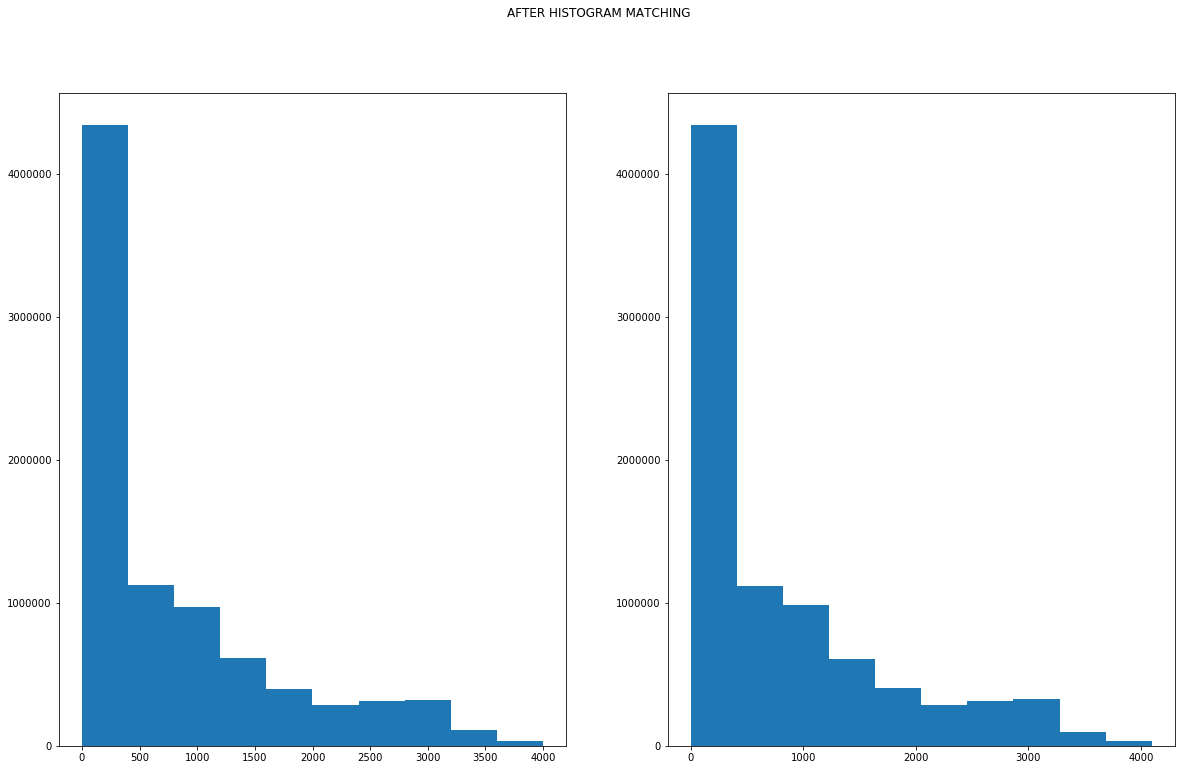

In [75]:
# function to do histogram matching
def get_histogram_matching_lut(h_input, h_template):
    ''' h_input: histogram to transfrom, h_template: reference'''
    if len(h_input) != len(h_template):
        print 'histograms length mismatch!'
        return False
    H_input = np.cumsum(h_input)
    H_template = np.cumsum(h_template)
    LUT = np.zeros(len(h_input))
    
    for i in range(len(H_template)):
        input_v = H_input[i]
        new_idx = (np.abs(H_template-input_v)).argmin()
        LUT[i] = new_idx
    
    return LUT,H_input,H_template

# rescale images between [0,1]
out_np = out_np.astype(float)
mammo_inv_norm = (mammo_inv - mammo_inv.flatten().min())/(mammo_inv.flatten().max() - mammo_inv.flatten().min())
mammo_out_norm = (out_np - out_np.flatten().min())/(out_np.flatten().max() - out_np.flatten().min())

n_bins = 4000 # define the number of bins
hist_inv = np.histogram(mammo_inv_norm, bins=np.linspace(0., 1., n_bins+1))
hist_out = np.histogram(mammo_out_norm, bins=np.linspace(0., 1., n_bins+1))

# compute LUT
LUT,H_input,H_template = get_histogram_matching_lut(hist_inv[0], hist_out[0])
assert(LUT        is not None),"LUT can not be None"
assert(H_input    is not None),"H_input can not be None"
assert(H_template is not None),"H_template can not be None"


# histograms before matching
plt.suptitle('BEFORE HISTOGRAM MATCHING')
plt.subplot(1,2,1); plt.hist(mammo_inv_norm.flatten())
plt.title('histogram input')
plt.subplot(1,2,2); plt.hist(mammo_out_norm.flatten())
plt.title('histogram target')
plt.show()

# plot cumulative histogram
plt.suptitle('CUMULATIVE HISTOGRAMS')
plt.subplot(1,2,1); plt.plot(H_input)
plt.title('cumulative histogram input')
plt.subplot(1,2,2); plt.plot(H_template)
plt.title('cumulative histogram target')
plt.show()    
    
# apply histogram matching
mammo_lut = LUT[(mammo_inv_norm * (n_bins-1)).astype(int)]

# visual result
plt.suptitle('VISUAL RESULT')
plt.subplot(1,2,1); plt.imshow(mammo_lut.squeeze(), cmap='gray')
plt.title('converted image')
plt.subplot(1,2,2); plt.imshow(out_np, cmap='gray')
plt.title('target')
plt.show()

# histograms after matching
plt.suptitle('AFTER HISTOGRAM MATCHING')
plt.subplot(1,2,1)
plt.hist(mammo_lut.flatten())
plt.subplot(1,2,2)
plt.hist(out_np.flatten())
plt.show()

#### Question

How did you pick the number of bins to use to do histogram matching? Does the result depend on the number of bins?

We looked at the max of the output-image and set our bins accordingly. With lower bins it does not find the best closest match on the other curve (our histogram is too sparse).

## 2. Stain normalization with histogram matching

<img src="./images/stain_examples.png" alt="HE1" style="width:150px" align="right">

In the previous exercise, we implemented a histogram matching function and used it to adapt a given mammography image to a given target image. In that case, the goal was to enhance relevant information in raw mammography data and make it visible as a gray-scale image.

The same technique can be applied to the field of digital pathology, but with the aim of solving a different problem, the variability of stain across images.
In pathology, tissue samples are cut and stained with specific dyes in order to enhance some tissues that are relevant for the diagnosis. The most commonly used staining is called eosin and hematoxylyn (H&E), which is routinely applied for diagnositc purposes.
The problem with H&E is that there is a large variability of stain across laboratories, and even in the same laboratory, when staining is done in different days of the week. This is because the final result strongly depends on the type and the density of the dyes and on the time the tissue is actually exposed to the dye.

The examples on the right are images of colorectal cancer tissue samples, extracted from a publicly available dataset (https://zenodo.org/record/53169#.WJRAC_krIuU), where the appearance, mainly the colour, of the HE-stained images, is different, event though these images were stained in the same lab.
Histogram matching is a technique that can help solve this problem, since we can think of adapting the distribution of colors per channel (R,G,B) by treating each channel independently.

When working with digital pathology images, it is worth noting that the image size is often big. Typical histopathology images are gigapixel images (think of Google maps to get an indea) in the order of 200,000px x 200,000px. However, for the sake of simplicity, in this assignment we will only use tiles of 5000x5000 px.

### Load the slides

(5000L, 5000L, 3L)
(5000L, 5000L, 3L)


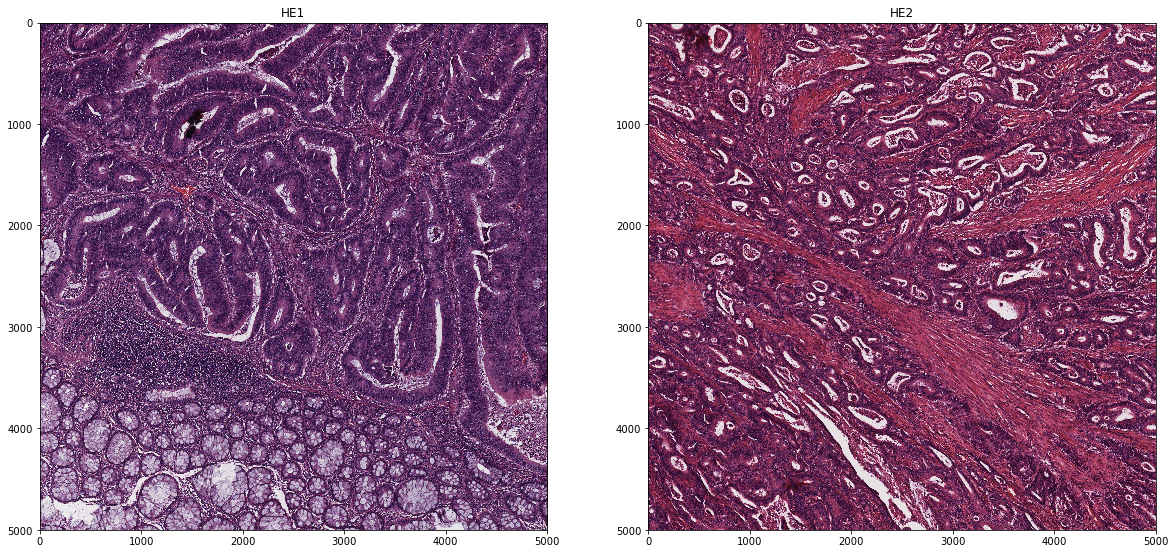

In [76]:
# load data
HE1 = np.asarray(Image.open('./data/CRC-Prim-HE-05_APPLICATION.tif'))
HE2 = np.asarray(Image.open('./data/CRC-Prim-HE-10_APPLICATION.tif'))

print HE1.shape
print HE2.shape

plt.subplot(1,2,1); plt.imshow(HE1); plt.title('HE1')
plt.subplot(1,2,2); plt.imshow(HE2); plt.title('HE2')

### Stain normalization

Implement your stain normalization function based on histogram matching based on the following definition.

In [77]:
def stain_normalization(input_img, target_img, n_bins=100):
    """ Stain normalization based on histogram matching. """
    input_img = input_img.astype(float)
    target_img = target_img.astype(float)
    input_norm = (input_img - input_img.flatten().min())/(input_img.flatten().max() - input_img.flatten().min())
    target_norm = (target_img - target_img.flatten().min())/(target_img.flatten().max() - target_img.flatten().min())
    normalized_img = np.zeros(input_img.shape)
    for i in range(3):
        in_hist = np.histogram(input_norm[:,:,i], bins=np.linspace(0., 1., n_bins+1))
        targ_hist = np.histogram(target_norm[:,:,i], bins=np.linspace(0., 1., n_bins+1))
        LUT,_,_ = get_histogram_matching_lut(in_hist[0],targ_hist[0]) # we just use the function from before
        normalized_img[:,:,i] = LUT[(input_norm[:,:,i] * (n_bins-1)).astype(int)]

    return normalized_img / n_bins

Now we can use the implemented function to do stain normalization and check the actual result.

(0.0, 0.98999999999999999)


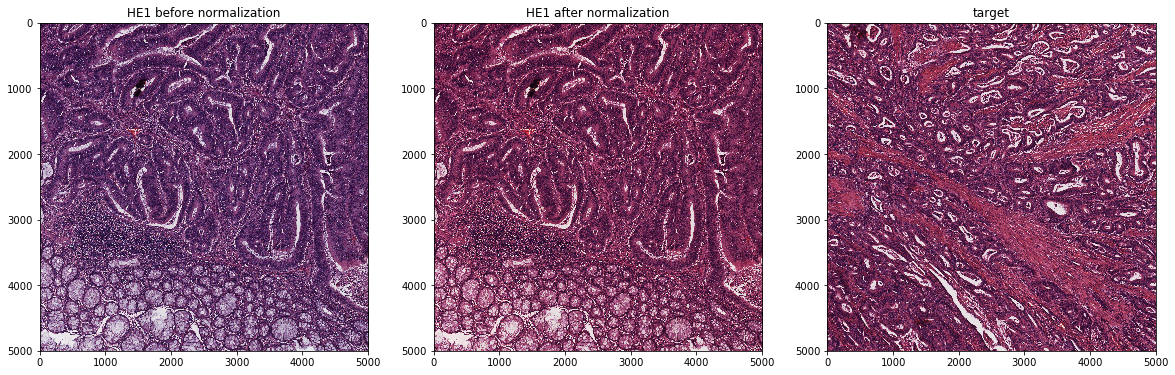

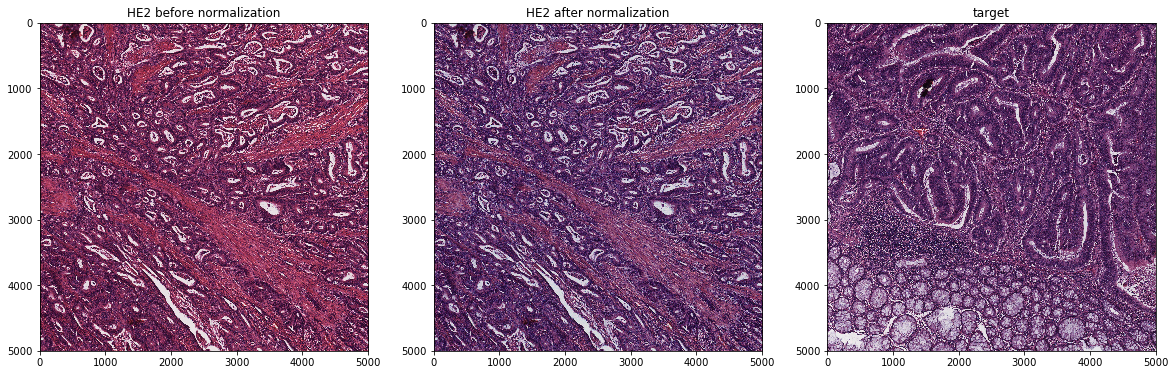

In [78]:
# transform HE1 to match HE2
HE1_norm = stain_normalization(HE1, HE2);
assert(HE1_norm is not None),"HE1_norm can not be None"
print(HE1_norm.min(),HE1_norm.max())
plt.subplot(1,3,1)
plt.imshow(HE1); plt.title('HE1 before normalization')
plt.subplot(1,3,2)
plt.imshow(HE1_norm); plt.title('HE1 after normalization')
plt.subplot(1,3,3)
plt.imshow(HE2); plt.title('target')
plt.show()

# transform HE2 to match HE1
HE2_norm = stain_normalization(HE2, HE1);
plt.subplot(1,3,1); plt.imshow(HE2)
plt.title('HE2 before normalization')
plt.subplot(1,3,2); plt.imshow(HE2_norm)
plt.title('HE2 after normalization')
plt.subplot(1,3,3); plt.imshow(HE1)
plt.title('target')
plt.show()

## 3. Trachea detection in chest CT

<img src="images/tracheaAxial.png"   align="right">

The last assignment is about automatic detection of the trachea in slices of a chest CT scan.
The detection of the trachea is often used as initialization of airway segmentation algorithms, where the position of the trachea is used as a seed point to grow segmentation methods.
For this purpose, we are going to develop a **blob detector** and process all slides of a given scan.
The idea is to implement an algorithm that reads an entire CT scan and returns the coordinates (x,y,z) of a point inside the trachea, which can be used as a reliable seed point for future analysis.
See the slice besides that shows where to find the trachea. For more images, visit:
- http://w-radiology.com/chest_ct.php
- http://w-radiology.com/chest_ct-parenchyma.php check it in Coronal view

### Loading DICOM

To develop our algorithm, we will use data from the publicly available dataset LIDC-IDRI (https://wiki.cancerimagingarchive.net/display/Public/LIDC-IDRI).
The database contains 1018 scans, but we will only use the first scan for this assignment, which you can find in the data folder.
The format of the chest CT file is DICOM, and for this we will need a dicom library in python.
The following code can be used to read all files in a given folder and to open one of those dicom files and convert it into a numpy array. 

In [79]:
# function that reads all files in a directory
def get_file_list(path,ext='',queue=''):
    if ext != '': return [os.path.join(path,f) for f in os.listdir(path) if f.endswith(''+queue+'.'+ext+'')],  [f for f in os.listdir(path) if f.endswith(''+queue+'.'+ext+'')]    
    else: return [os.path.join(path,f) for f in os.listdir(path)]

In [80]:
# load the first scan from LIDC-IDRI
scan_path = './data/LIDC-IDRI/LIDC-IDRI-0001/1.3.6.1.4.1.14519.5.2.1.6279.6001.298806137288633453246975630178/1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636438705059720603192'

# read all dicom files in the folder
dcm_files = sorted(get_file_list(scan_path, 'dcm')[0])
n_slices = len(dcm_files)

# read one slice and print dicom information
slice_idx = 0
ct_slice_dicom = dicom.read_file(dcm_files[slice_idx])
print ct_slice_dicom

# convert the slice to a numpy array
ct_slice_numpy = ct_slice_dicom.pixel_array
dims = ct_slice_numpy.shape

# print scan information
print '{} dicom files of dimension {} found'.format(n_slices, dims)

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.14519.5.2.1.6279.6001.143451261327128179989900675595
(0008, 0020) Study Date                          DA: '20000101'
(0008, 0021) Series Date                         DA: '20000101'
(0008, 0022) Acquisition Date                    DA: '20000101'
(0008, 0023) Content Date                        DA: '20000101'
(0008, 0024) Overlay Date                        DA: '20000101'
(0008, 0025) Curve Date                          DA: '20000101'
(0008, 002a) Acquisition DateTime                DT: '20000101'
(0008, 0030) Study Time                          TM: ''
(0008, 0032) Acquisition Time                    TM: ''
(0008, 0033) Content Time                        TM: ''
(0008, 0050) Accession Number               

For convenience, we store all slices in a scan (3D) matrix

In [81]:
scan = np.zeros((dims[0], dims[1], n_slices))
for f in range(n_slices):
    ds = dicom.read_file(dcm_files[f])
    scan[:,:,ds.InstanceNumber-1] = ds.pixel_array
print scan.shape

(512L, 512L, 133L)


### Seed point detection

<img src="images/gaussian.gif" align="right" width="250">


A blob detector is based on a Gaussian function, which has to be applied at a given scale.
As a first step, define a function to make Gaussian kernels in 2D, given a value for **sigma in millimiters** given by:

\begin{equation}
G(x,y) = \frac{1}{2\pi\sigma^2}\exp^{-(x^2+y^2)/(2\sigma^2)}
\end{equation}

Do not forget to take into account for the voxel size in x and y direction of the CT scan when designing the filters.
This information can be found in the header of the dicom file.

In [1]:
def gaussian_2d(sigma_mm, voxel_size):
    x_vec = np.arange(-sigma_mm*3.3,sigma_mm*3.3,voxel_size[0]) # *3.3(~99%) SD should cover most of the area
    y_vec = np.arange(-sigma_mm*3.3,sigma_mm*3.3,voxel_size[1])
    xx,yy = np.meshgrid(x_vec,y_vec)
    kernel = (1/(2*np.pi*sigma_mm**2)) * np.exp(-(xx**2+yy**2)/(2*sigma_mm**2))
    return kernel, xx, yy 

#### Laplacian of Gaussian (LoG) <img src="images/LoG.png" width="250" align="right">
Now define a function to make the Laplacian of Gaussian defined by:

\begin{equation}
\nabla^2G(x,y) = \frac{\partial^2G(x,y)}{\partial x^2} + \frac{\partial^2G(x,y)}{\partial y^2}
\end{equation}



In [2]:
def laplacian_of_gaussian(g):
    gxx = np.gradient(np.gradient(g,axis=0),axis=0)
    gyy = np.gradient(np.gradient(g,axis=1),axis=1)
    LoG = gxx+gyy
    return LoG,gxx,gyy

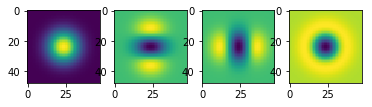

In [3]:
# compute LoG
g,x,y = gaussian_2d(5, [0.7, 0.7])
assert(g is not None),"g can not be None"
assert(x is not None),"x can not be None"
assert(y is not None),"y can not be None"

LoG,gxx,gyy = laplacian_of_gaussian(g)
assert(LoG is not None),"LoG can not be None"
assert(gxx is not None),"gxx can not be None"
assert(gyy is not None),"gyy can not be None"

#visualize the filters
plt.subplot(1,4,1)
plt.imshow(g)
plt.subplot(1,4,2)
plt.imshow(gxx)
plt.subplot(1,4,3)
plt.imshow(gyy)
plt.subplot(1,4,4)
plt.imshow(LoG)
plt.show()


We can also visualize our Gaussian filter using a surface-like visualization

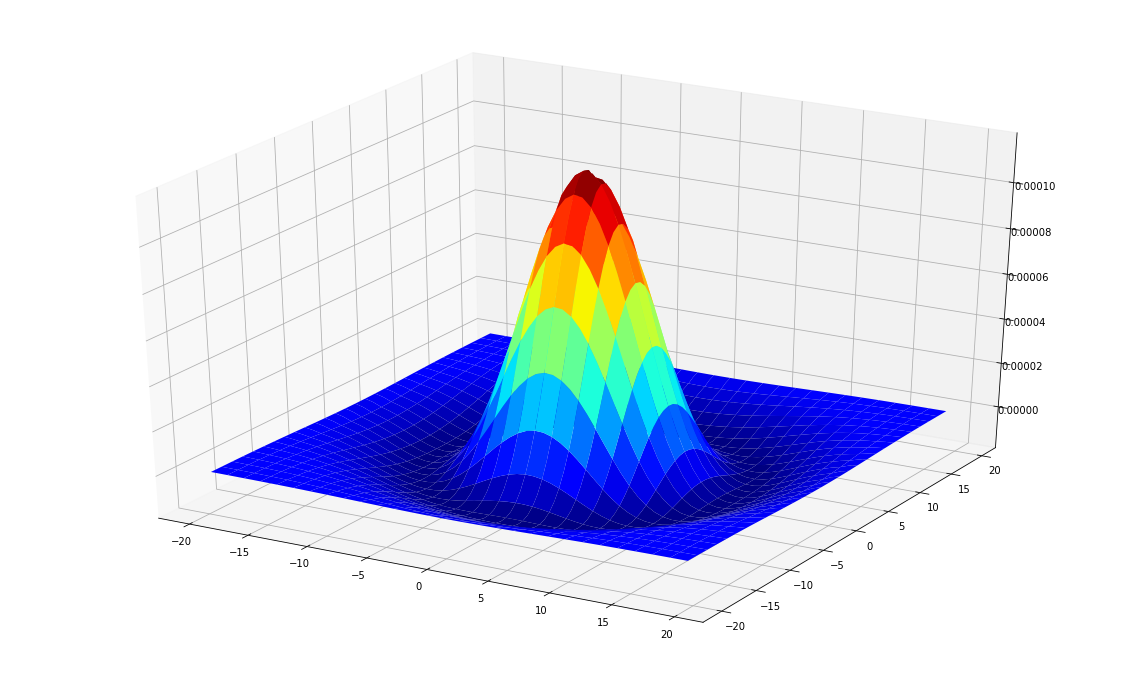

In [90]:
# Filter surface visualization
g,x,y = gaussian_2d(6.0, [0.7, 0.7])
LoG,gxx,gyy = laplacian_of_gaussian(g)
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(x, y, LoG*-1, antialiased=True, cmap=cm.jet, linewidth=0)
plt.show()

We also provide a function that extracts the area that belongs to the thorax for each slice. It is based on some morphology operations that we have not seen yet, so don't worry too much about that, just use it as a black box if you think it can be useful in your implementation.

In [86]:
# function to get the area of the thorax
print(ct_slice_numpy.shape)
def get_thorax(ct_slice_numpy):
    thorax = (ct_slice_numpy > 500)
    thorax = scipy.ndimage.morphology.binary_fill_holes(thorax)
    label, num_label = scipy.ndimage.label(thorax)
    size = np.bincount(label.ravel())
    biggest_label = size[1:].argmax() + 1
    thorax = (label == biggest_label)
    return thorax    

(512L, 512L)


Now we apply LoG to all slices in the image. We apply the filter by using the convolution operation. When the filter size becomes big, working in the frequency domain is much faster. For this purpose we can use the fast fourier transform. Think of the size of the filter, whether one filter size is enough or whether multiple sizes has to be used. Tune the scale(s) based on realistic assumptions.

.....................................................................................................................................

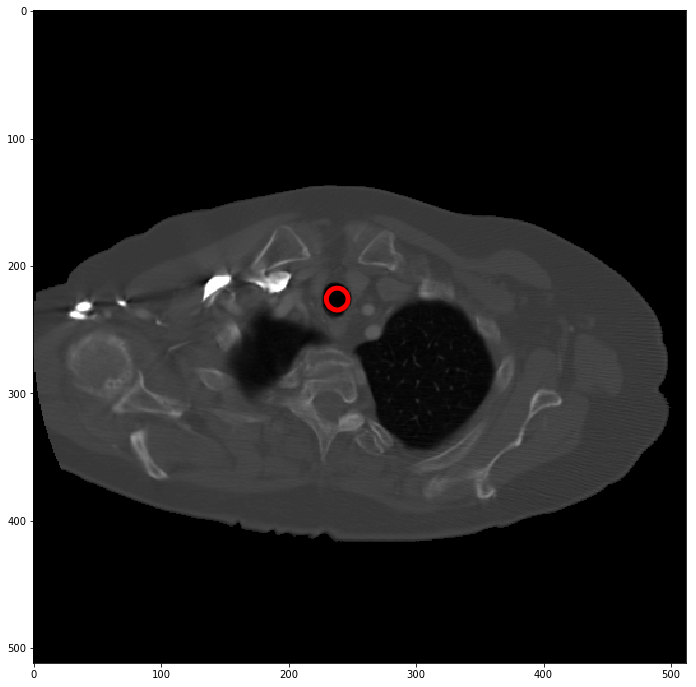


Found at x: 226.0,y: 238.0 in image: 14 with sigma: 6.0 mm


In [87]:
import sys
def trachea_one_slice(ct_slice):
    ct_slice[~get_thorax(ct_slice)]=0
    # apparently the trachea is from 10-25mm, so we take that/2 as our sigma
    sigmas = np.arange(5,14)                                                  
    xy_act = np.zeros((len(sigmas),3))
    for i in np.arange(len(sigmas)): 
        # voxel size is fixed in this example. We could also read it from the Dicom:{Pixel Spacing}.
        g,_,_ = gaussian_2d(sigmas[i],(0.7,0.7))                               
        LoG,_,_ = laplacian_of_gaussian(g) 
        # multiply by sigma^2 to achieve a normalized version of the laplacian
        LoG = LoG * sigmas[i]**2                                               
        # using 'same' to have same dimensions later
        conv = scipy.signal.fftconvolve(ct_slice, LoG*-1 , mode='same')    
        # get "highest" activation pixel, in our case of inverted LoG that is the min.
        activation = np.min(conv)                                              
        (x,y) = np.unravel_index(conv.argmin(), conv.shape)
        xy_act[i,:] = [x,y,activation]
        
    # highest activation at x,y
    idx = np.argmin(xy_act,axis=0)[2]
    best_x, best_y = xy_act[idx,0:2]
    
    return [best_x, best_y, activation, sigmas[idx]]


def trachea_seed_point_detection(scan):
    xyz_act = np.zeros((scan.shape[-1],4))
    for i in range(scan.shape[2]):
        sys.stdout.write('.')
        xyz_act[i,:] = trachea_one_slice(scan[:,:,i])
    idx = np.argmin(xyz_act,axis=0)[2]
    best_x, best_y = xyz_act[idx,0:2]
    sigma = xyz_act[idx,3]

    return best_x, best_y, idx, sigma  # coordinates of the selected seed point (you can also call it (i,j,k))


x,y,z, sigma = trachea_seed_point_detection(scan);
best_ct = scan[:,:,z]
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
circ = plt.Circle((y, x), radius=sigma*1.42, fc='none', ec='r',lw=5)
plt.imshow(best_ct, cmap='gray')
ax.add_patch(circ)
plt.show()
print('\nFound at x: {},y: {} in image: {} with sigma: {} mm'.format(x,y,z, sigma))

#### Question

Which value of sigma did you use for trachea detection? Did you use only one value or multiple values? What are the criteria that you assumed in order to pick the best sigma(s)?

According to the literature the trachea is around 10-25mm in diameter, so I used a radius of 5-14 sigma_mm to search within that range. Because the LoG changes its magnitude with different sigma I used a normalized version of the $LoG=LoG*\sigma^2$ to be able to compare the different sigma scale activations. I used the pixel with the highest activation as the slice result and the slice with the highest activation as an overall result.

#### Question

Is the seed-point that you found unique? How many valid seed points could you find in your analysis? Which one did you report? Why?

There were many valid seed points. I chose to take the one with the highest activation over all images.